# Using Anomaly Detection

In [491]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output, display
from sklearn import preprocessing
import copy
from matplotlib.pyplot import figure
from scipy.fft import fft
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# Code retrieved from Paolo

In [492]:
from sklearn.metrics import roc_curve,roc_auc_score

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def plot_history(history):
    losses1 = [x['val_loss1'] for x in history]
    losses2 = [x['val_loss2'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()
    
def histogram(y_test,y_pred):
    plt.figure(figsize=(12,6))
    plt.hist([y_pred[y_test==0],
              y_pred[y_test==1]],
            bins=20,
            color = ['#82E0AA','#EC7063'],stacked=True)
    plt.title("Results",size=20)
    plt.grid()
    plt.show()
    
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]
    
def confusion_matrix(target, predicted, perc=False):

    data = {'y_Actual':    target,
            'y_Predicted': predicted
            }
    df = pd.DataFrame(data, columns=['y_Predicted','y_Actual'])
    confusion_matrix = pd.crosstab(df['y_Predicted'], df['y_Actual'], rownames=['Predicted'], colnames=['Actual'])
    
    if perc:
        sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')
    else:
        sns.heatmap(confusion_matrix, annot=True, fmt='d')
    plt.show()

In [523]:
import torch
import torch.nn as nn

device = get_default_device()

class Encoder(nn.Module):
    def __init__(self, in_size, latent_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, int(in_size/2))
        self.linear2 = nn.Linear(int(in_size/2), int(in_size/4))
        self.linear3 = nn.Linear(int(in_size/4), latent_size)
        self.relu = nn.ReLU(True)

    def forward(self, w):
        out = self.linear1(w)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        z = self.relu(out)
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_size, int(out_size/4))
        self.linear2 = nn.Linear(int(out_size/4), int(out_size/2))
        self.linear3 = nn.Linear(int(out_size/2), out_size)
        self.relu = nn.ReLU(True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        out = self.linear1(z)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        w = self.sigmoid(out)
        return w
    
class UsadModel(nn.Module):
    def __init__(self, w_size, z_size):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)

    def training_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
        loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
        return loss1,loss2

    def validation_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
        loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
        return {'val_loss1': loss1, 'val_loss2': loss2}

    def validation_epoch_end(self, outputs):
        batch_losses1 = [x['val_loss1'] for x in outputs]
        epoch_loss1 = torch.stack(batch_losses1).mean()
        batch_losses2 = [x['val_loss2'] for x in outputs]
        epoch_loss2 = torch.stack(batch_losses2).mean()
        return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))
    
def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch=to_device(batch,device)
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss1.backward(retain_graph=True)
            loss2.backward()
            optimizer1.step()
            optimizer2.step()
            optimizer1.zero_grad()
            optimizer2.zero_grad()
        result = evaluate(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    
def testing(model, test_loader, alpha=.5, beta=.5):
    results=[]
    for [batch] in test_loader:
        batch=to_device(batch,device)
        w1=model.decoder1(model.encoder(batch))
        w2=model.decoder2(model.encoder(w1))
        results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

# Retrieve Dataset from csv (Other notebooks create the dataset)  

In [971]:
# Get dataset from Marri001 (assumed to be in same directory)
df_dataset = pd.read_csv("AllChannels_MarRi001_Features_0_5.csv")
df_dataset = df_dataset.drop(columns="Unnamed: 0")

In [972]:
# Get dataset from Marri007 (assumed to be in same directory)
test_dataset = pd.read_csv("AllChannels_MarRi007_Features_0_5.csv")
test_dataset = test_dataset.drop(columns="Unnamed: 0")

In [981]:
# Training: Select only relevant columns(Y1 Means amplitude of channel CzOz etc..)
# This version I am selecting the Amplitudes, you can change the columns to select the features
# rather than the amplitudes
df_dataset = df_dataset[['Y1', 'Y2','Y3','Y4','Y5','Y6','Y7','Label']]
df_dataset

,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Label
0,1.304895e-09,4.940636e-11,-1.020918e-09,-2.311242e-09,1.313036e-09,3.121958e-09,-2.805573e-10,1
1,-7.938572e-08,5.043589e-08,-3.290712e-08,5.658916e-08,-2.930116e-07,-4.001363e-08,3.206176e-09,1
2,-1.599883e-07,1.007983e-07,-6.471217e-08,1.154752e-07,-5.871687e-07,-8.309342e-08,6.671783e-09,1
3,-2.404142e-07,1.511128e-07,-9.635541e-08,1.743315e-07,-8.809898e-07,-1.260603e-07,1.009510e-08,1
4,-3.205750e-07,2.013554e-07,-1.277564e-07,2.331427e-07,-1.174307e-06,-1.688572e-07,1.345503e-08,1
...,...,...,...,...,...,...,...,...
423445,-1.363488e-06,1.216847e-07,-2.097951e-07,1.157218e-06,3.184088e-06,4.251672e-06,2.224195e-07,0
423446,-1.022070e-06,9.034575e-08,-1.561160e-07,8.686200e-07,2.382527e-06,3.184455e-06,1.668279e-07,0
423447,-6.799393e-07,5.892527e-08,-1.023139e-07,5.794292e-07,1.579366e-06,2.115073e-06,1.111271e-07,0
423448,-3.373335e-07,2.745097e-08,-4.843058e-08,2.898430e-07,7.751408e-07,1.044252e-06,5.535350e-08,0


In [982]:
# Testing: Select only relevant columns (Y1 Means amplitude of channel CzOz etc..)
# This version I am selecting the Amplitudes, you can change the columns to select the features
# rather than the amplitudes
test_dataset = test_dataset[['Y1', 'Y2','Y3','Y4','Y5','Y6','Y7','Label']]
test_dataset

,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Label
0,5.265063e-10,1.556932e-09,-2.565888e-09,-3.276038e-09,-2.415748e-09,-3.284981e-09,1.157457e-09,1
1,-1.705059e-07,-2.087657e-08,-1.865038e-07,-2.415324e-08,7.110107e-08,-1.736704e-07,-1.302019e-07,1
2,-3.414325e-07,-4.330928e-08,-3.702910e-07,-4.497998e-08,1.445667e-07,-3.439097e-07,-2.614752e-07,1
3,-5.121474e-07,-6.573979e-08,-5.537778e-07,-6.570715e-08,2.179292e-07,-5.138585e-07,-3.925763e-07,1
4,-6.825448e-07,-8.816668e-08,-7.368150e-07,-8.628577e-08,2.911369e-07,-6.833724e-07,-5.234190e-07,1
...,...,...,...,...,...,...,...,...
375095,-9.178068e-07,-5.711272e-07,3.544911e-07,1.289185e-06,2.651073e-06,5.329471e-07,-8.309154e-07,0
375096,-6.888767e-07,-4.279464e-07,2.662812e-07,9.678200e-07,1.988959e-06,3.994025e-07,-6.237511e-07,0
375097,-4.595691e-07,-2.845136e-07,1.778098e-07,6.458075e-07,1.325566e-06,2.655015e-07,-4.162453e-07,0
375098,-2.300096e-07,-1.409131e-07,8.916386e-08,3.233630e-07,6.613221e-07,1.313633e-07,-2.085117e-07,0


In [863]:
# For another version, I trained on the features (so I deleted the amplitudes)

# del df_dataset["X1"]
# del df_dataset["Y1"]

# del df_dataset["X2"]
# del df_dataset["Y2"]

# del df_dataset["X3"]
# del df_dataset["Y3"]

# del df_dataset["X4"]
# del df_dataset["Y4"]

# del df_dataset["X5"]
# del df_dataset["Y5"]

# del df_dataset["X6"]
# del df_dataset["Y6"]

# del df_dataset["X7"]
# del df_dataset["Y7"]

# df_dataset

,stds1,varis1,means1,meds1,maxs1,mins1,rms1,ampli1,peakPSD1,avgPSD1,...,stds7,varis7,means7,meds7,maxs7,mins7,rms7,ampli7,peakPSD7,avgPSD7
0,4.005613e-06,1.604494e-11,-4.523173e-10,2.914786e-09,2.039111e-05,-0.000020,0.000004,0.000041,2.070719e-12,1.301470e-14,...,9.270635e-09,8.594467e-17,1.471372e-08,1.509278e-08,2.857188e-08,-2.805573e-10,1.739075e-08,2.885244e-08,8.379124e-20,1.617702e-20
1,4.005639e-06,1.604514e-11,-2.492418e-10,3.798468e-09,2.039111e-05,-0.000020,0.000004,0.000041,2.070814e-12,1.300341e-14,...,7.423163e-09,5.510334e-17,3.330964e-08,3.513559e-08,4.196702e-08,1.917962e-08,3.412676e-08,2.278740e-08,5.737381e-20,1.016690e-20
2,4.005651e-06,1.604524e-11,9.103314e-11,4.731320e-09,2.039111e-05,-0.000020,0.000004,0.000041,2.070911e-12,1.298912e-14,...,3.883564e-08,1.508207e-15,-1.224565e-07,-1.200771e-07,-6.527531e-08,-1.867685e-07,1.284671e-07,1.214932e-07,1.473151e-18,2.708176e-19
3,4.005637e-06,1.604513e-11,4.413856e-10,5.739237e-09,2.039111e-05,-0.000020,0.000004,0.000041,2.070888e-12,1.298418e-14,...,6.933654e-08,4.807555e-15,-5.044676e-07,-5.028032e-07,-3.984283e-07,-6.154936e-07,5.092103e-07,2.170653e-07,4.661140e-18,8.704297e-19
4,4.005625e-06,1.604503e-11,6.675258e-10,6.915135e-09,2.039111e-05,-0.000020,0.000004,0.000041,2.070709e-12,1.299257e-14,...,8.090566e-08,6.545725e-15,-1.042311e-06,-1.042511e-06,-9.153740e-07,-1.168644e-06,1.045446e-06,2.532701e-07,6.319494e-18,1.195071e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21168,3.777066e-06,1.426623e-11,-9.399615e-06,-1.084671e-05,5.508816e-09,-0.000013,0.000010,0.000013,1.799700e-13,5.459427e-15,...,7.783213e-08,6.057840e-15,1.886684e-06,1.890878e-06,2.002095e-06,1.758693e-06,1.888288e-06,2.434016e-07,5.807844e-18,1.128916e-18
21169,4.103588e-06,1.683943e-11,-8.873957e-06,-1.025976e-05,5.508816e-09,-0.000013,0.000010,0.000013,1.293524e-13,4.137303e-15,...,9.162477e-09,8.395099e-17,2.193489e-06,2.197556e-06,2.201609e-06,2.173329e-06,2.193508e-06,2.828022e-08,9.813768e-20,2.667402e-20
21170,3.816914e-06,1.456883e-11,-7.270446e-06,-7.822616e-06,5.508816e-09,-0.000013,0.000008,0.000013,7.152640e-14,2.938784e-15,...,6.857426e-08,4.702430e-15,1.979935e-06,1.984967e-06,2.079533e-06,1.865250e-06,1.981122e-06,2.142822e-07,4.615148e-18,8.446864e-19
21171,2.713347e-06,7.362251e-12,-4.720867e-06,-4.845714e-06,5.508816e-09,-0.000009,0.000005,0.000009,2.072573e-14,1.370250e-15,...,1.298415e-07,1.685880e-14,1.276159e-06,1.279475e-06,1.474435e-06,1.067941e-06,1.282747e-06,4.064943e-07,1.634778e-17,3.050661e-18


In [983]:
# Select only the samples that have alpha waves
normal = 1   # 1 = alpha, 0 = not alpha
X_train_normal = df_dataset[df_dataset["Label"] == normal].copy()
display(X_train_normal)

,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Label
0,1.304895e-09,4.940636e-11,-1.020918e-09,-2.311242e-09,1.313036e-09,3.121958e-09,-2.805573e-10,1
1,-7.938572e-08,5.043589e-08,-3.290712e-08,5.658916e-08,-2.930116e-07,-4.001363e-08,3.206176e-09,1
2,-1.599883e-07,1.007983e-07,-6.471217e-08,1.154752e-07,-5.871687e-07,-8.309342e-08,6.671783e-09,1
3,-2.404142e-07,1.511128e-07,-9.635541e-08,1.743315e-07,-8.809898e-07,-1.260603e-07,1.009510e-08,1
4,-3.205750e-07,2.013554e-07,-1.277564e-07,2.331427e-07,-1.174307e-06,-1.688572e-07,1.345503e-08,1
...,...,...,...,...,...,...,...,...
287495,1.853741e-06,-1.444213e-06,1.296879e-06,-4.875773e-07,1.208313e-05,-3.569310e-06,4.235810e-06,1
287496,1.978830e-06,-1.453193e-06,1.395242e-06,-5.149901e-07,1.240531e-05,-3.659167e-06,4.324554e-06,1
287497,2.102950e-06,-1.461358e-06,1.493424e-06,-5.416554e-07,1.271765e-05,-3.747674e-06,4.410664e-06,1
287498,2.226043e-06,-1.468710e-06,1.591385e-06,-5.675539e-07,1.301991e-05,-3.834785e-06,4.494088e-06,1


In [984]:
del X_train_normal["Label"]

In [985]:
# Standardize data
ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(X_train_normal),columns = X_train_normal.columns)

In [986]:
X_train_normal = df_scaled

# Training

In [987]:
# Reshaping the data
window_size_2 = 1
windows = X_train_normal.to_numpy(copy=True)
windows_normal=windows[np.arange(window_size_2)[None, :] + np.arange(windows.shape[0]-window_size_2)[:, None]]

print(windows.shape)
print(windows_normal.shape)

(269999, 7)
(269998, 1, 7)


In [988]:
# Using the implementation from Paolo
import torch
import torch.utils.data as data_utils

BATCH_SIZE = 7919
N_EPOCHS = 40
hidden_size = 40
#hidden_size = 40
fraction = 0.8

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(fraction * windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(fraction * windows_normal.shape[0])):]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [989]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 1.1724, val_loss2: 1.1910
Epoch [1], val_loss1: 1.1764, val_loss2: -0.0002
Epoch [2], val_loss1: 1.1753, val_loss2: -0.3945
Epoch [3], val_loss1: 1.1731, val_loss2: -0.5977
Epoch [4], val_loss1: 1.1633, val_loss2: -0.7134
Epoch [5], val_loss1: 1.1495, val_loss2: -0.7817
Epoch [6], val_loss1: 1.1376, val_loss2: -0.8281
Epoch [7], val_loss1: 1.1354, val_loss2: -0.8700
Epoch [8], val_loss1: 1.1425, val_loss2: -0.9103
Epoch [9], val_loss1: 1.1517, val_loss2: -0.9449
Epoch [10], val_loss1: 1.1600, val_loss2: -0.9730
Epoch [11], val_loss1: 1.1610, val_loss2: -0.9902
Epoch [12], val_loss1: 1.1621, val_loss2: -1.0048
Epoch [13], val_loss1: 1.1634, val_loss2: -1.0176
Epoch [14], val_loss1: 1.1648, val_loss2: -1.0289
Epoch [15], val_loss1: 1.1655, val_loss2: -1.0383
Epoch [16], val_loss1: 1.1656, val_loss2: -1.0460
Epoch [17], val_loss1: 1.1658, val_loss2: -1.0529
Epoch [18], val_loss1: 1.1659, val_loss2: -1.0591
Epoch [19], val_loss1: 1.1661, val_loss2: -1.0647
Epoch [20],

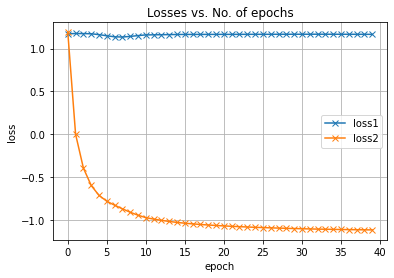

In [990]:
plot_history(history)

In [991]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

# Testing

In [992]:
# Start of testing
labels = test_dataset["Label"].to_numpy(copy=True)

In [993]:
# del test_dataset["X1"]
# del test_dataset["Y1"]

# del test_dataset["X2"]
# del test_dataset["Y2"]

# del test_dataset["X3"]
# del test_dataset["Y3"]

# del test_dataset["X4"]
# del test_dataset["Y4"]

# del test_dataset["X5"]
# del test_dataset["Y5"]

# del test_dataset["X6"]
# del test_dataset["Y6"]

# del test_dataset["X7"]
# del test_dataset["Y7"]
del test_dataset["Label"]

test_dataset

,Y1,Y2,Y3,Y4,Y5,Y6,Y7
0,5.265063e-10,1.556932e-09,-2.565888e-09,-3.276038e-09,-2.415748e-09,-3.284981e-09,1.157457e-09
1,-1.705059e-07,-2.087657e-08,-1.865038e-07,-2.415324e-08,7.110107e-08,-1.736704e-07,-1.302019e-07
2,-3.414325e-07,-4.330928e-08,-3.702910e-07,-4.497998e-08,1.445667e-07,-3.439097e-07,-2.614752e-07
3,-5.121474e-07,-6.573979e-08,-5.537778e-07,-6.570715e-08,2.179292e-07,-5.138585e-07,-3.925763e-07
4,-6.825448e-07,-8.816668e-08,-7.368150e-07,-8.628577e-08,2.911369e-07,-6.833724e-07,-5.234190e-07
...,...,...,...,...,...,...,...
375095,-9.178068e-07,-5.711272e-07,3.544911e-07,1.289185e-06,2.651073e-06,5.329471e-07,-8.309154e-07
375096,-6.888767e-07,-4.279464e-07,2.662812e-07,9.678200e-07,1.988959e-06,3.994025e-07,-6.237511e-07
375097,-4.595691e-07,-2.845136e-07,1.778098e-07,6.458075e-07,1.325566e-06,2.655015e-07,-4.162453e-07
375098,-2.300096e-07,-1.409131e-07,8.916386e-08,3.233630e-07,6.613221e-07,1.313633e-07,-2.085117e-07


In [994]:
X_test = test_dataset
display(X_test)
print(labels)

,Y1,Y2,Y3,Y4,Y5,Y6,Y7
0,5.265063e-10,1.556932e-09,-2.565888e-09,-3.276038e-09,-2.415748e-09,-3.284981e-09,1.157457e-09
1,-1.705059e-07,-2.087657e-08,-1.865038e-07,-2.415324e-08,7.110107e-08,-1.736704e-07,-1.302019e-07
2,-3.414325e-07,-4.330928e-08,-3.702910e-07,-4.497998e-08,1.445667e-07,-3.439097e-07,-2.614752e-07
3,-5.121474e-07,-6.573979e-08,-5.537778e-07,-6.570715e-08,2.179292e-07,-5.138585e-07,-3.925763e-07
4,-6.825448e-07,-8.816668e-08,-7.368150e-07,-8.628577e-08,2.911369e-07,-6.833724e-07,-5.234190e-07
...,...,...,...,...,...,...,...
375095,-9.178068e-07,-5.711272e-07,3.544911e-07,1.289185e-06,2.651073e-06,5.329471e-07,-8.309154e-07
375096,-6.888767e-07,-4.279464e-07,2.662812e-07,9.678200e-07,1.988959e-06,3.994025e-07,-6.237511e-07
375097,-4.595691e-07,-2.845136e-07,1.778098e-07,6.458075e-07,1.325566e-06,2.655015e-07,-4.162453e-07
375098,-2.300096e-07,-1.409131e-07,8.916386e-08,3.233630e-07,6.613221e-07,1.313633e-07,-2.085117e-07


[1 1 1 ... 0 0 0]


In [995]:
# Standardize test data using input scaler
X_test =  pd.DataFrame(ss.transform(test_dataset),columns = test_dataset.columns)
display(X_test)

,Y1,Y2,Y3,Y4,Y5,Y6,Y7
0,0.000017,-0.000024,-0.000461,-0.000631,0.000077,-0.000756,0.000997
1,-0.043051,-0.010664,-0.030999,-0.004916,0.005513,-0.015869,-0.058082
2,-0.086093,-0.021302,-0.061512,-0.009191,0.010946,-0.030970,-0.117123
3,-0.129081,-0.031940,-0.091975,-0.013445,0.016371,-0.046045,-0.176086
4,-0.171989,-0.042576,-0.122363,-0.017669,0.021784,-0.061081,-0.234933
...,...,...,...,...,...,...,...
375095,-0.231231,-0.271622,0.058819,0.264644,0.196296,0.046809,-0.373230
375096,-0.173584,-0.203718,0.044174,0.198685,0.147334,0.034963,-0.280058
375097,-0.115841,-0.135694,0.029486,0.132592,0.098278,0.023086,-0.186731
375098,-0.058035,-0.067591,0.014768,0.066411,0.049159,0.011188,-0.093303


In [996]:
#LOAD TEST DATA
start = 100
end = 175
X_test = test_dataset
X_test_arr = X_test.to_numpy(copy=True)
windows_test=X_test_arr[np.arange(window_size_2)[None, :] + np.arange(X_test_arr.shape[0]-window_size_2)[:, None]]
print(windows_test.shape)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_test).float().view(([windows_test.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

(375099, 1, 7)


In [997]:
results=testing(model, test_loader)
y_pred = np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                                results[-1].flatten().detach().cpu().numpy()])
if normal==1:
    #y_pred = y_pred
    y_pred = -y_pred+1
y_test = labels

y_pred = np.append(y_pred,0)
print(len(y_pred))
print(len(y_test))


375100
375100


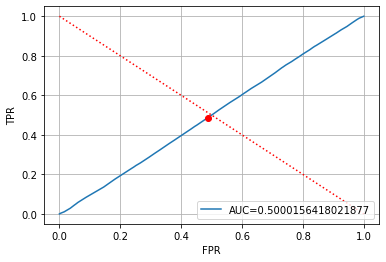

[0.81737679]


In [999]:
train_channel = 'allButCzOz'
test_channel = 'allButCzOz'
threshold = ROC(y_test[:len(y_pred)],y_pred)
print(threshold)
threshold = threshold[0]

In [1000]:
# Select the predictions that have a value higher than the threshold retrieved from the ROC
y_pred_01 = np.where(y_pred > threshold, 1, 0)

In [1006]:
accuracy_score(y_test, y_pred_01, normalize=True)

0.4914182884564116

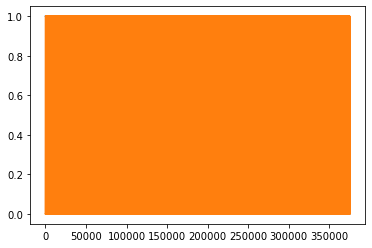

In [1002]:
plt.plot(y_test)
plt.plot(y_pred_01)

In [1003]:
# Retrieved from Paolo
def smooth_output(y, threshold, window):
    indices = np.where(np.diff(y)!=0)[0]
    y_out = y.copy()
    y_len = len(y)
    half = int(window/2)

    for i in range(len(indices)-1):
        if indices[i+1]-indices[i]<threshold:
            center = int((indices[i]+indices[i+1])/2)
            if sum(y[max(0,center-half):min(center+half,y_len)])<half:
                y_out[indices[i]+1:indices[i+1]+1] = 0
            else:
                y_out[indices[i]+1:indices[i+1]+1] = 1
    
    if y_len-indices[-1]<threshold:
        center = int((indices[-1]+y_len)/2)
        if sum(y[max(0,center-half):min(center+half,y_len)])<half:
            y_out[indices[-1]+1:y_len] = 0
        else:
            y_out[indices[-1]+1:y_len] = 1

    return y_out

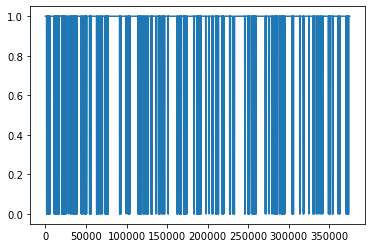

In [1004]:
step_threshold = 2500
step_window = 2500

y_smooth = smooth_output(y_pred_01, step_threshold, step_window)
plt.figure()
y_smooth = [abs(x-1) for x in y_smooth]
plt.plot(y_smooth)

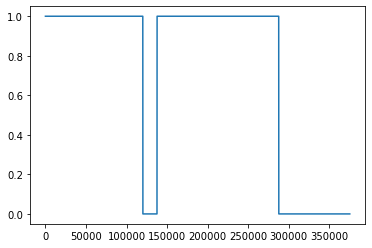

In [1005]:
plt.plot(y_test)

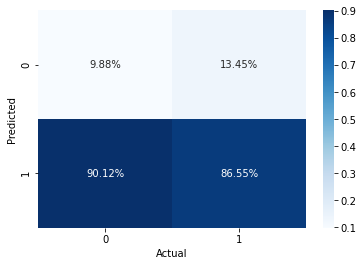

In [1008]:
fig=confusion_matrix(y_test[:len(y_smooth)],y_smooth,perc=True)

# In this section the values have been recorded manually after trying and testing manually on several datasets

<Figure size 1600x1200 with 0 Axes>

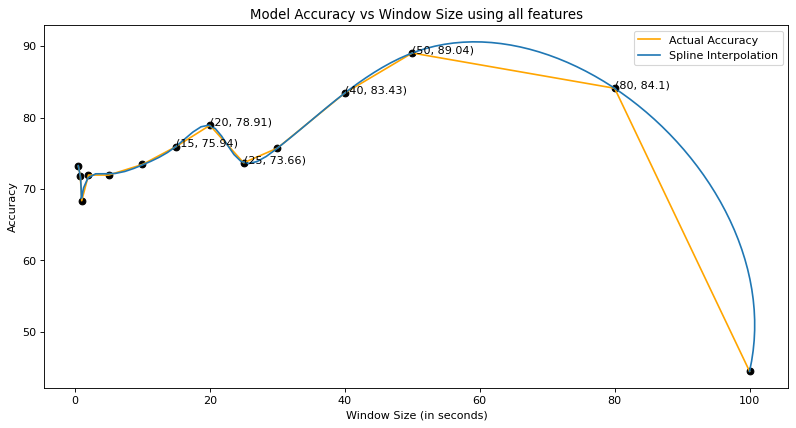

In [970]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')

def annotate_points(ax, A, B):
    for xy in zip(A, B):
        ax.annotate('(%s, %s)'  % xy , xy=xy)

points = [(0.5,73.17),(0.8,71.82),(1,68.35),(2,71.94),(5,71.94),(10,73.42),(15,75.94)]
points = points + [(20,78.91),(25,73.66),(30,75.71),(40,83.43),(50,89.04),(80,84.1),(100,44.45)]
x, y = zip(*points)

fig = plt.figure(figsize=(12, 6),dpi=80)
ax = fig.add_subplot(111)
plt.scatter(x, y, color='black')
annotate_points(ax, x[10:13], y[10:13])
annotate_points(ax, x[6:9], y[6:9])

tck,u = interpolate.splprep([x, y], s=0.2)
unew = np.arange(0, 1.01, 0.01)
out = interpolate.splev(unew, tck)
plt.ylabel("Accuracy")
plt.xlabel("Window Size (in seconds)")
plt.plot(x, y, 'orange', out[0], out[1])
plt.legend(['Actual Accuracy', 'Spline Interpolation'])
plt.title("Model Accuracy vs Window Size using all features")
plt.show()